# **Download the ISIC 2019data:**

train set data:

In [ ]:
! wget https://s3.amazonaws.com/isic-challenge-data/2019/ISIC_2019_Training_Input.zip

train set Metadata:

In [ ]:
! wget https://s3.amazonaws.com/isic-challenge-data/2019/ISIC_2019_Training_Metadata.csv

train set GroundTruth:

In [ ]:
! wget https://s3.amazonaws.com/isic-challenge-data/2019/ISIC_2019_Training_GroundTruth.csv

Unziping the training input file:

In [ ]:
! unzip /content/ISIC_2019_Training_Input.zip

images are put in another folder so using ImageDataGenerator be possible.

In [ ]:
!mkdir training_image_set

In [ ]:
!mv  "/content/ISIC_2019_Training_Input" "/content/training_image_set"

# **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.regularizers import Regularizer, L1L2, L1, L2, serialize
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
images_path = '/content/training_image_set/ISIC_2019_Training_Input'
Training_GroundTruth_path = '/content/ISIC_2019_Training_GroundTruth.csv'

In [ ]:
print(len(os.listdir(images_path)))

25333


In [ ]:
#train_gt = Training Ground Truth
train_gt_df = pd.read_csv(Training_GroundTruth_path)

train_gt_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_gt_df[train_gt_df['UNK']==1]

In [ ]:
for index, img in enumerate(train_gt_df.image):
    img = img+'.jpg'
    train_gt_df.image[index]=img


#there is no data for 'UNK', so i am not gonna count it in my process
train_gt_df.drop(['UNK'], axis=1, inplace=True)

In [ ]:
train_gt_df.head(5)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels=list(train_gt_df.columns[1:])

In [ ]:
test_set_ratio = 0.10
val_set_ratio = 0.20

test_rows = (np.random.rand(int(test_set_ratio*train_gt_df.shape[0]))*train_gt_df.shape[0]).astype(int)
test_df =  train_gt_df.iloc[test_rows]
test_df = test_df.reset_index().drop(['index'], axis=1)
train_gt_df.drop(test_rows, axis=0, inplace=True)
train_gt_df = train_gt_df.reset_index().drop(['index'], axis=1)


val_rows = (np.random.rand(int(val_set_ratio*train_gt_df.shape[0]))*train_gt_df.shape[0]).astype(int)
val_df = train_gt_df.iloc[val_rows]
val_df = val_df.reset_index().drop(['index'], axis=1)
train_gt_df.drop(val_rows, axis=0, inplace=True)
train_gt_df = train_gt_df.reset_index().drop(['index'], axis=1)

In [ ]:
print('train set size: ', train_gt_df.shape[0])
print('test set size: ', test_df.shape[0])
print('cross validation set size: ', val_df.shape[0])

train set size:  18799
test set size:  2533
cross validation set size:  4587


In [ ]:
target_size = (224,224)
inputs_shape = (224,224,3)
num_classes = 8

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255)

train_set_gen = data_gen.flow_from_dataframe(dataframe=train_gt_df, directory=images_path, x_col='image', y_col=list(train_gt_df.columns)[1:], batch_size=64, shuffle=True, class_mode='raw', target_size=target_size)
val_set_gen = data_gen.flow_from_dataframe(dataframe=val_df, directory=images_path, x_col='image', y_col=list(val_df.columns)[1:], batch_size=64, shuffle=True, class_mode='raw', target_size=target_size)
test_set_gen = data_gen.flow_from_dataframe(dataframe=test_df, directory=images_path, x_col='image', y_col=list(val_df.columns)[1:], batch_size=64, shuffle=False, class_mode='raw', target_size=target_size)

Found 18799 validated image filenames.
Found 4587 validated image filenames.
Found 2533 validated image filenames.


# **Define loss function and metrics**

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 
def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

# **Define customize Resnet with sigmoid**

In [ ]:
model_resnet50_drop_maxnorm_L2 = Sequential()

model_resnet50_drop_maxnorm_L2.add(ResNet50(include_top=False, weights='imagenet', input_shape=inputs_shape))

model_resnet50_drop_maxnorm_L2.add(GlobalMaxPooling2D())

model_resnet50_drop_maxnorm_L2.add(Dense(512, activation='relu', kernel_regularizer=L2(l2=0.015), kernel_constraint=MaxNorm(2)))
model_resnet50_drop_maxnorm_L2.add(Dropout(0.5))

model_resnet50_drop_maxnorm_L2.add(BatchNormalization())

model_resnet50_drop_maxnorm_L2.add(Dense(1024, activation='relu', kernel_regularizer=L2(l2=0.03), kernel_constraint=MaxNorm(2)))
model_resnet50_drop_maxnorm_L2.add(Dropout(0.6))

model_resnet50_drop_maxnorm_L2.add(BatchNormalization())

model_resnet50_drop_maxnorm_L2.add(Dense(256, activation='relu', kernel_regularizer=L2(l2=0.01), kernel_constraint=MaxNorm(2)))
model_resnet50_drop_maxnorm_L2.add(Dropout(0.5))

model_resnet50_drop_maxnorm_L2.add(Dense(8, activation='sigmoid'))

model_resnet50_drop_maxnorm_L2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1macro])

In [ ]:
model_resnet50_drop_maxnorm_L2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1024)             

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max", verbose=0,
                    save_best_only=True, save_weights_only=False, save_freq="epoch")
]

In [ ]:
STEP_SIZE_TRAIN=train_set_gen.n//train_set_gen.batch_size
STEP_SIZE_VALID=val_set_gen.n//val_set_gen.batch_size
STEP_SIZE_TEST=test_set_gen.n//test_set_gen.batch_size


result = model_resnet50_drop_maxnorm_L2.fit(train_set_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_set_gen, validation_steps=STEP_SIZE_VALID, callbacks=callbacks, epochs=16)


Epoch 1/16
293/293 [==============================] - 566s 2s/step - loss: 31.3556 - accuracy: 0.4896 - f1macro: 0.6200 - val_loss: 28.6825 - val_accuracy: 0.1789 - val_f1macro: 0.4057
Epoch 2/16
293/293 [==============================] - 574s 2s/step - loss: 23.1340 - accuracy: 0.6074 - f1macro: 0.6732 - val_loss: 20.2900 - val_accuracy: 0.5117 - val_f1macro: 0.6050
Epoch 3/16
293/293 [==============================] - 559s 2s/step - loss: 16.9013 - accuracy: 0.6632 - f1macro: 0.6879 - val_loss: 14.7047 - val_accuracy: 0.5473 - val_f1macro: 0.6544
Epoch 4/16
293/293 [==============================] - 558s 2s/step - loss: 12.2687 - accuracy: 0.7010 - f1macro: 0.6957 - val_loss: 10.5106 - val_accuracy: 0.6822 - val_f1macro: 0.6757
Epoch 5/16
293/293 [==============================] - 556s 2s/step - loss: 8.8458 - accuracy: 0.7563 - f1macro: 0.7086 - val_loss: 7.6929 - val_accuracy: 0.6917 - val_f1macro: 0.6703
Epoch 6/16
293/293 [==============================] - 556s 2s/step - loss: 6.

# **Evaluation**

In [ ]:
model_resnet50_drop_maxnorm_L2.metrics_names

['loss', 'accuracy', 'f1macro']

In [ ]:
losses = pd.DataFrame(model_resnet50_drop_maxnorm_L2.history.history)
losses.head()

,loss,accuracy,f1macro,val_loss,val_accuracy,val_f1macro
0,31.355642,0.489571,0.619992,28.682489,0.178917,0.405733
1,23.133972,0.607391,0.673170,20.289976,0.511664,0.604976
2,16.901323,0.663173,0.687909,14.704703,0.547315,0.654395
3,12.268728,0.700984,0.695711,10.510583,0.682218,0.675748
4,8.845849,0.756284,0.708582,7.692906,0.691681,0.670320


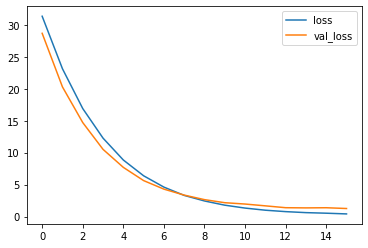

In [ ]:
losses[['loss','val_loss']].plot()

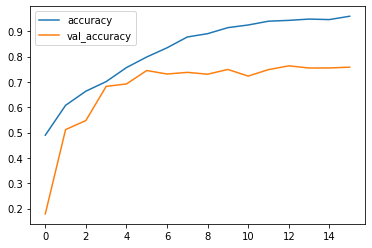

In [ ]:
losses[['accuracy','val_accuracy']].plot()

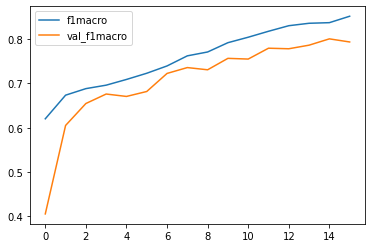

In [ ]:
losses[['f1macro','val_f1macro']].plot()

In [ ]:
model_resnet50_drop_maxnorm_L2.evaluate_generator(test_set_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.2385190725326538, 0.7651006579399109, 0.792849063873291]

# **Define customize Resnet with softmax**

In [ ]:
model_resnet50_drop_L2_softmax = Sequential()

model_resnet50_drop_L2_softmax.add(ResNet50(include_top=False, weights='imagenet', input_shape=inputs_shape))

model_resnet50_drop_L2_softmax.add(GlobalMaxPooling2D())

model_resnet50_drop_L2_softmax.add(Dense(512, activation='relu', kernel_regularizer=L2(l2=0.015), kernel_constraint=MaxNorm(2)))
model_resnet50_drop_L2_softmax.add(Dropout(0.5))

model_resnet50_drop_L2_softmax.add(BatchNormalization())

model_resnet50_drop_L2_softmax.add(Dense(1024, activation='relu', kernel_regularizer=L2(l2=0.03), kernel_constraint=MaxNorm(2)))
model_resnet50_drop_L2_softmax.add(Dropout(0.6))

model_resnet50_drop_L2_softmax.add(BatchNormalization())

model_resnet50_drop_L2_softmax.add(Dense(256, activation='relu', kernel_regularizer=L2(l2=0.01), kernel_constraint=MaxNorm(2)))
model_resnet50_drop_L2_softmax.add(Dropout(0.5))

model_resnet50_drop_L2_softmax.add(Dense(8, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model_resnet50_drop_L2_softmax.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1macro])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model_resnet50_drop_L2_softmax.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [ ]:
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max", verbose=0,
                    save_best_only=True, save_weights_only=False, save_freq="epoch")
]

In [ ]:
STEP_SIZE_TRAIN=train_set_gen.n//train_set_gen.batch_size
STEP_SIZE_VALID=val_set_gen.n//val_set_gen.batch_size
STEP_SIZE_TEST=test_set_gen.n//test_set_gen.batch_size


result = model_resnet50_drop_L2_softmax.fit(train_set_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_set_gen, validation_steps=STEP_SIZE_VALID, callbacks=callbacks, epochs=16)


Epoch 1/16
293/293 [==============================] - 517s 2s/step - loss: 33.4968 - accuracy: 0.4249 - f1macro: 0.6606 - val_loss: 28.4558 - val_accuracy: 0.5176 - val_f1macro: 0.5255
Epoch 2/16
293/293 [==============================] - 541s 2s/step - loss: 24.2352 - accuracy: 0.6023 - f1macro: 0.7717 - val_loss: 20.9526 - val_accuracy: 0.5172 - val_f1macro: 0.5223
Epoch 3/16
293/293 [==============================] - 481s 2s/step - loss: 17.5143 - accuracy: 0.6560 - f1macro: 0.8002 - val_loss: 15.1756 - val_accuracy: 0.5548 - val_f1macro: 0.7237
Epoch 4/16
293/293 [==============================] - 479s 2s/step - loss: 12.5960 - accuracy: 0.7048 - f1macro: 0.8297 - val_loss: 10.7987 - val_accuracy: 0.6593 - val_f1macro: 0.7928
Epoch 5/16
293/293 [==============================] - 483s 2s/step - loss: 9.0550 - accuracy: 0.7530 - f1macro: 0.8570 - val_loss: 7.7913 - val_accuracy: 0.7205 - val_f1macro: 0.8206
Epoch 6/16
293/293 [==============================] - 476s 2s/step - loss: 6.

# **Evaluation**

In [ ]:
model_resnet50_drop_L2_softmax.metrics_names

['loss', 'accuracy', 'f1macro']

In [ ]:
losses = pd.DataFrame(model_resnet50_drop_L2_softmax.history.history)
losses.head()

,loss,accuracy,f1macro,val_loss,val_accuracy,val_f1macro
0,33.496796,0.424873,0.660588,28.455816,0.517606,0.525539
1,24.235218,0.602295,0.771701,20.952618,0.517165,0.522310
2,17.514282,0.655991,0.800204,15.175593,0.554798,0.723731
3,12.596029,0.704777,0.829664,10.798728,0.659331,0.792769
4,9.054955,0.753029,0.856970,7.791296,0.720511,0.820589


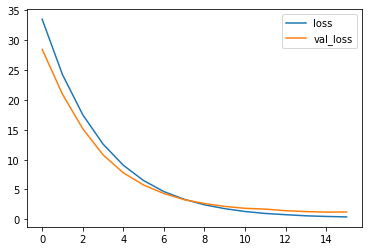

In [ ]:
losses[['loss','val_loss']].plot()

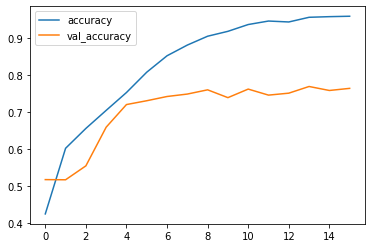

In [ ]:
losses[['accuracy','val_accuracy']].plot()

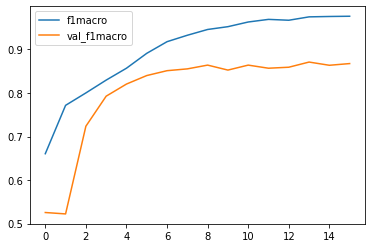

In [ ]:
losses[['f1macro','val_f1macro']].plot()

In [ ]:
model_resnet50_drop_L2_softmax.evaluate_generator(test_set_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.2435121536254883, 0.7556257247924805, 0.8599104881286621]